In [1]:
# Spark init#save the files in the g drive folder - first two commands
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
!pip install -q findspark
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!head -5 /content/drive/MyDrive/data/zip_code_market_tracker.tsv000

period_begin	period_end	period_duration	region_type	region_type_id	table_id	is_seasonally_adjusted	region	city	state	state_code	property_type	property_type_id	median_sale_price	median_sale_price_mom	median_sale_price_yoy	median_list_price	median_list_price_mom	median_list_price_yoy	median_ppsf	median_ppsf_mom	median_ppsf_yoy	median_list_ppsf	median_list_ppsf_mom	median_list_ppsf_yoy	homes_sold	homes_sold_mom	homes_sold_yoy	pending_sales	pending_sales_mom	pending_sales_yoy	new_listings	new_listings_mom	new_listings_yoy	inventory	inventory_mom	inventory_yoy	months_of_supply	months_of_supply_mom	months_of_supply_yoy	median_dom	median_dom_mom	median_dom_yoy	avg_sale_to_list	avg_sale_to_list_mom	avg_sale_to_list_yoy	sold_above_list	sold_above_list_mom	sold_above_list_yoy	price_drops	price_drops_mom	price_drops_yoy	off_market_in_two_weeks	off_market_in_two_weeks_mom	off_market_in_two_weeks_yoy	parent_metro_region	parent_metro_region_metro_code	last_updated
2017-07-01	2017-09-30	90	zip code	2

In [5]:
df = spark.read.csv('/content/drive/MyDrive/data/zip_code_market_tracker.tsv000', sep='\t',header=True)

In [ ]:
df.show(5)

+------------+----------+---------------+-----------+--------------+--------+----------------------+---------------+----+--------+----------+--------------------+----------------+-----------------+---------------------+---------------------+-----------------+---------------------+---------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+----------+--------------------+--------------------+-------------+--------------------+--------------------+------------+--------------------+--------------------+---------+--------------------+--------------------+----------------+--------------------+--------------------+----------+--------------+--------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------+---------------+---------------+-----------------------+---------------------------+---------------------------+-----------

In [6]:
df_2 = df.drop("region_type","region_type_id","is_seasonally_adjusted","city","table_id","period_duration","months_of_supply","price_drops","median_sale_price_mom", "median_sale_price_yoy","median_list_price_mom","median_list_price_yoy","median_ppsf_mom","median_ppsf_yoy","median_list_ppsf_mom","median_list_ppsf_yoy","homes_sold_mom","homes_sold_yoy", "pending_sales_mom","pending_sales_yoy","new_listings_mom","new_listings_yoy","inventory_mom","inventory_yoy","months_of_supply_mom","months_of_supply_yoy","median_dom_mom","median_dom_yoy","avg_sale_to_list_mom","avg_sale_to_list_yoy","sold_above_list_mom","sold_above_list_yoy","price_drops_mom","price_drops_yoy","off_market_in_two_weeks_mom","off_market_in_two_weeks_yoy")

In [ ]:
df_2.show(5)

+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+-------------------+------------------------------+-------------------+
|period_begin|period_end|         region|   state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks|parent_metro_region|parent_metro_region_metro_code|       last_updated|
+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+------------

In [ ]:
import pyspark.sql.functions as func

In [ ]:
#Distinct count of states in Redfin Dataset
df_states = df_2.select("state_code").distinct().count()
df_states

47

In [7]:
#Calculating difference of list and sale price and the percentage of that difference
df_3 = df_2.withColumn('DiffOfList&SalePrice', df_2.median_sale_price - df_2.median_list_price)

In [ ]:
df_3.show(5)

+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+-------------------+------------------------------+-------------------+--------------------+
|period_begin|period_end|         region|   state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks|parent_metro_region|parent_metro_region_metro_code|       last_updated|DiffOfList&SalePrice|
+------------+----------+---------------+--------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+-

In [8]:
from pyspark.sql.functions import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import sum, col, desc

In [ ]:
#Grouping by period begin and calculating average median sale price
df_4 = df_3.groupBy(year('period_begin')).agg({'median_sale_price':'avg'}).sort(desc(year(df_3.period_begin)))
df_4.show()

+------------------+----------------------+
|year(period_begin)|avg(median_sale_price)|
+------------------+----------------------+
|              2021|    401835.58340094466|
|              2020|    362583.99056237936|
|              2019|     327523.0125517681|
|              2018|     316830.0760047208|
|              2017|     299386.2661495026|
|              2016|     281396.6058442422|
|              2015|     262589.8273512335|
|              2014|    236888.15264449312|
|              2013|    222190.99115307556|
|              2012|     203568.0687816029|
+------------------+----------------------+



In [ ]:
#Grouping by state and calculating average median sale price
df_5 = df_3.groupBy('state_code').agg({'median_sale_price':'avg'}).sort(desc('state_code'))
df_5.show()

+----------+----------------------+
|state_code|avg(median_sale_price)|
+----------+----------------------+
|        WV|    176733.04015009382|
|        WI|     185107.8762431838|
|        WA|     354272.3985604759|
|        VT|    238820.19213696892|
|        VA|     346225.8756535498|
|        UT|    295702.58772075834|
|        TX|    228807.55905834926|
|        TN|     202194.1801501387|
|        SC|      220761.695163139|
|        RI|    279043.00771734567|
|        PA|     194589.5040639796|
|        OR|    297355.45440297923|
|        OK|    146274.00966060188|
|        OH|     161808.5762915278|
|        NY|     417966.7571129145|
|        NV|     267678.2945781298|
|        NM|     326475.7256774404|
|        NJ|    335297.06581715145|
|        NH|     252588.6696552374|
|        NE|    186050.03780650455|
+----------+----------------------+
only showing top 20 rows



In [10]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import datetime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import sum, col, desc
from pyspark.sql.functions import lit

In [11]:
#Calculating difference between median sale price

my_window = Window.partitionBy().orderBy("period_begin")

df_3 = df_3.withColumn("prev_value", F.lag("median_sale_price").over(my_window))
df_3 = df_3.withColumn("diff", F.when(F.isnull(df_3.median_sale_price - df_3.prev_value), 0)
                              .otherwise(df_3.median_sale_price - df_3.prev_value))

df_3.show()

+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+--------------------+------------------------------+-------------------+--------------------+----------+---------+
|period_begin|period_end|         region|        state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks| parent_metro_region|parent_metro_region_metro_code|       last_updated|DiffOfList&SalePrice|prev_value|     diff|
+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+------------------+---------

In [ ]:
#Spliting Region Column and add a new column named zip code
from pyspark.sql.functions import split
 
df_zipcode = df_3.withColumn("ZIP_Code", split(col("region"), ": ").getItem(1))
df_zipcode.show()

+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+----------+-------------+------------+---------+----------+-------------------+-------------------+-----------------------+--------------------+------------------------------+-------------------+--------------------+----------+---------+--------+
|period_begin|period_end|         region|        state|state_code|       property_type|property_type_id|median_sale_price|median_list_price|       median_ppsf|  median_list_ppsf|homes_sold|pending_sales|new_listings|inventory|median_dom|   avg_sale_to_list|    sold_above_list|off_market_in_two_weeks| parent_metro_region|parent_metro_region_metro_code|       last_updated|DiffOfList&SalePrice|prev_value|     diff|ZIP_Code|
+------------+----------+---------------+-------------+----------+--------------------+----------------+-----------------+-----------------+----------

In [ ]:
#Counting distint zip code
zip_count = df_3.select('region').distinct().count()
zip_count


18817

In [ ]:
#Grouping by state and calculating average difference of median sale price
df_6 = df_3.groupBy('state_code').agg({'diff':'avg'}).sort(desc('state_code'))
df_6.show()

+----------+-------------------+
|state_code|          avg(diff)|
+----------+-------------------+
|        WV|-110777.98944652909|
|        WI|-122361.54200876813|
|        WA|  59249.19562622059|
|        VT| -50301.31878932735|
|        VA|  52927.93969713126|
|        UT| -9741.546015946202|
|        TX| -62754.06183071034|
|        TN|-106925.99217211554|
|        SC| -91074.74045999847|
|        RI| -9920.015277194456|
|        PA| -95371.50993527369|
|        OR|  6345.578071571748|
|        OK|-146627.44282516264|
|        OH|-128739.81936908046|
|        NY| 119195.89756566526|
|        NV| -22759.28677023048|
|        NM| 28224.968005223636|
|        NJ| 33476.293601061276|
|        NH| -37777.25948736588|
|        NE|-104403.57103467734|
+----------+-------------------+
only showing top 20 rows



Text(0.5, 1.0, 'Date Vs. Median Sale Price of Redfin Data')

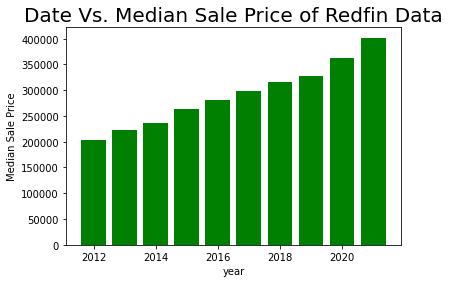

In [ ]:
# convert dataframe to dictionary 
# Visualuizing Date vs. Median Sale Price of Redfin Data
import matplotlib.pyplot as plt
dict = df_4.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='g')
plt.xlabel("year",fontsize=10)
plt.ylabel("Median Sale Price",fontsize=10)
plt.title("Date Vs. Median Sale Price of Redfin Data",fontsize=20)

In [ ]:
#Grouping by state_code and calculating sum of homes sold
df_7 = df_3.groupBy('state_code').agg({'homes_sold':'sum'}).sort(desc('state_code'))
df_7.show()

+----------+---------------+
|state_code|sum(homes_sold)|
+----------+---------------+
|        WV|       231252.0|
|        WI|      3154496.0|
|        WA|      6200008.0|
|        VT|       341600.0|
|        VA|      5122254.0|
|        UT|      2483498.0|
|        TX|    1.6001554E7|
|        TN|      4232576.0|
|        SC|      3155930.0|
|        RI|       831618.0|
|        PA|      6835910.0|
|        OR|      3433796.0|
|        OK|      2358712.0|
|        OH|      7672028.0|
|        NY|      6753402.0|
|        NV|      3229686.0|
|        NM|       157080.0|
|        NJ|      5826306.0|
|        NH|      1188340.0|
|        NE|      1069648.0|
+----------+---------------+
only showing top 20 rows



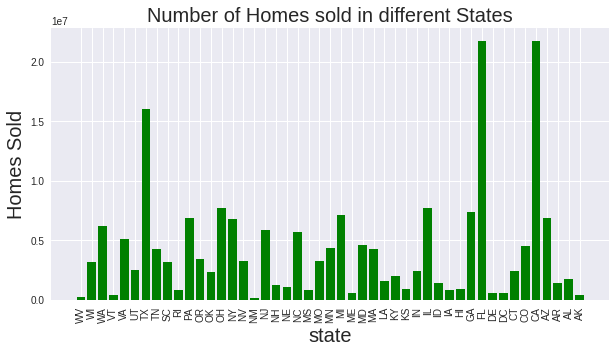

In [ ]:
# convert dataframe to dictionary 
# Visualizing number of homes sold in different states
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

dict = df_7.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='g')
plt.xlabel("state",fontsize=20)
plt.xticks(rotation=90)
plt.ylabel("Homes Sold",fontsize=20)
plt.title("Number of Homes sold in different States",fontsize=20)
plt.gcf().set_size_inches(10,5)

In [12]:
#Grouping by year and calculating sum of homes sold 
df_8 = df_3.groupBy(year('period_begin')).agg({'homes_sold':'sum'}).sort(desc(year('period_begin')))
df_8.show()

+------------------+---------------+
|year(period_begin)|sum(homes_sold)|
+------------------+---------------+
|              2021|    2.1533092E7|
|              2020|    2.2866564E7|
|              2019|    2.1703092E7|
|              2018|     2.129468E7|
|              2017|     2.146457E7|
|              2016|     2.086591E7|
|              2015|    1.9596474E7|
|              2014|    1.6961434E7|
|              2013|    1.6730922E7|
|              2012|    1.4728378E7|
+------------------+---------------+



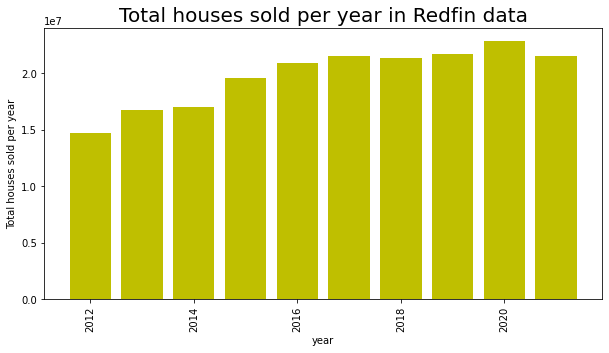

In [13]:
#Visualizing total house sold per yaer using Redfin data
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

dict = df_8.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='y')
plt.xlabel("year",fontsize=10)
plt.xticks(rotation=90)

plt.ylabel("Total houses sold per year",fontsize=10)
plt.title("Total houses sold per year in Redfin data",fontsize=20)
plt.gcf().set_size_inches(10,5)

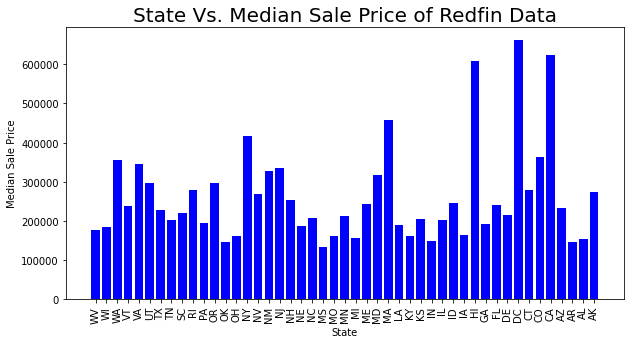

In [ ]:
# convert dataframe to dictionary 
# Visualizing State vs. Median Sale Price of Redfin Data
import matplotlib.pyplot as plt
dict = df_5.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='b')
plt.xlabel("State",fontsize=10)
plt.xticks(rotation=90)
plt.ylabel("Median Sale Price",fontsize=10)
plt.title("State Vs. Median Sale Price of Redfin Data",fontsize=20)
plt.gcf().set_size_inches(10,5)

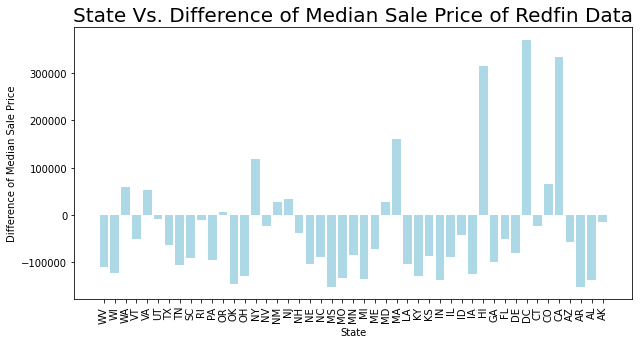

In [ ]:
#Visualizing State vs. Difference of median Sale Price of Redfin data
import matplotlib.pyplot as plt
dict = df_6.rdd.collectAsMap()
plt.bar(list(dict.keys()), dict.values(), color='lightblue')
plt.xlabel("State",fontsize=10)
plt.xticks(rotation=90)
plt.ylabel("Difference of Median Sale Price",fontsize=10)
plt.title("State Vs. Difference of Median Sale Price of Redfin Data",fontsize=20)
plt.gcf().set_size_inches(10,5)

In [ ]:
## https://api.census.gov/data/2020/acs/acs5/variables.html lists all the possible variable keys for the API Request
## Below provides a DF with the ZIP Code and the Median household income.
## Need to initialize spark session first
##CODE
import requests 
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import *




In [ ]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
#from pyspark.sql import *
census_API_call = requests.get('https://api.census.gov/data/2020/acs/acs5?get=NAME,B19013_001E&for=zip%20code%20tabulation%20area:*&key=46d133e794f5998e012ea4e0d83d6fb6085136b0')
census_JSON = census_API_call.json()

schema = StructType([
   StructField("ZCTA5_Code", StringType(), True),
   StructField("Median_Income", StringType(), True),
   StructField("ZIP_Code", StringType(), True)])
census_df = spark.createDataFrame(census_JSON[1:], schema)


In [ ]:
census_df.count()
census_df.show(n=10)

+-----------+-------------+--------+
| ZCTA5_Code|Median_Income|ZIP_Code|
+-----------+-------------+--------+
|ZCTA5 29590|        30985|   29590|
|ZCTA5 93306|        54450|   93306|
|ZCTA5 93660|        39625|   93660|
|ZCTA5 93110|        93264|   93110|
|ZCTA5 93212|        42983|   93212|
|ZCTA5 14895|        48778|   14895|
|ZCTA5 14006|        56017|   14006|
|ZCTA5 67514|        46875|   67514|
|ZCTA5 67844|        47262|   67844|
|ZCTA5 67861|        59201|   67861|
+-----------+-------------+--------+
only showing top 10 rows



In [ ]:
# Join two dataframes to reflect the sales price and median income based on the zipcode
df_merged = df_zipcode.join(census_df, 'ZIP_Code',)\
                                                .select(df_zipcode['ZIP_Code'], 
                                                df_zipcode['median_sale_price'],
                                                df_zipcode['median_list_price'],
                                                df_zipcode['property_type'],
                                                df_zipcode['period_begin'],
                                                df_zipcode['homes_sold'],
                                                df_zipcode['state'], 
                                                census_df['Median_Income']).sort(df_zipcode.period_begin.asc())

In [ ]:
df_merged.show(30)

+--------+-----------------+-----------------+--------------------+------------+----------+-------------+-------------+
|ZIP_Code|median_sale_price|median_list_price|       property_type|period_begin|homes_sold|        state|Median_Income|
+--------+-----------------+-----------------+--------------------+------------+----------+-------------+-------------+
|   14204|            89000|           104700|Single Family Res...|  2012-01-01|         2|     New York|        22989|
|   30002|            46550|           196200|     All Residential|  2012-01-01|        14|      Georgia|        66339|
|   14204|            14023|            50000|Multi-Family (2-4...|  2012-01-01|         1|     New York|        22989|
|   02053|           166500|           219900|         Condo/Co-op|  2012-01-01|         2|Massachusetts|       139688|
|   15634|            57500|           109900|     All Residential|  2012-01-01|         3| Pennsylvania|   -666666666|
|   02053|           283000|           3